![](https://cocalc.com/blobs/JFM-notebooks-banner.jpg?uuid=9d16d75a-893e-446e-be43-1dc27b5505d8)



In [3]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
plt.style.use(['science', 'no-latex'])


 **Generalised Actuator Disk (AD) model**
 
 Note that variables are dimensionless: distances are normalised by disk diameter $D$,  and velocities are normalised by the incoming velocity $U_0$.
 
 Equation labels in the code refer to the model formulation in the accompanying manuscript.

In [4]:
#--------------------------------
# MAIN FUNCTION
#--------------------------------
def new_AD(E1, E2, I, *,
           a=None, ct=None,
           L_up=5, L_down=30,
           tol=5e-3, r=0.05, max_iter=500,
           n_eval_up=1000, n_eval_down=10000):
    """
Exactly one of (a, ct) must be provided. The code will compute the other missing value (a or ct), as well as upstream and downstream variations of axial velocity U, pressure P, and cross-sectional width of CV, sigma.

    Parameters
    ----------
    E1, E2 : float
        Entrainment coefficients in Eqs. (2.5)–(2.6).
    I : float
        Ambient turbulence intensity in Eq. (2.6).
    a : float, optional (keyword-only)
        Induction factor at the disk; if supplied, Ct is obtained iteratively.
    ct : float, optional (keyword-only)
        Thrust coefficient; if supplied, a is obtained iteratively.
    L_up : float
        Upstream extent (in diameters).
    L_down : float
        Downstream extent (in diameters).
    tol : float
        Convergence tolerance for iteration (|new − old| ≤ tol).
    r : float
        Relaxation factor in the iteration update (0 < r ≤ 1).
    max_iter : int
        Maximum number of iterations permitted for each case.
    n_eval_up : int
        Number of points for the upstream region.
    n_eval_down : int
        Number of points for the downstream region.

    Returns
    -------
    x : ndarray
        Axial coordinates (dimensionless), concatenated as [upstream, downstream].
    sigma : ndarray
        Cross-sectional width of the control voluem σ/D.
    U : ndarray
        Axial velocity U/U0.
    Ue : ndarray
        Entrainment velocity U_e/U0 from Eq. (2.7).
    result_scalar : float
        The computed scalar: `Ct` if `a` was provided, or `a` if `ct` was provided.

    Notes
    -----
    • Arguments after the single '*' are keyword-only (Python syntax).
    """

    # Exactly one of a, ct must be set
    if (a is None) == (ct is None):
        raise ValueError("Provide exactly one of 'a' or 'ct', not both or neither.")

    R_hat = 0.5  # disk radius in units of D

    # ----------------------------------------------------------------------
    # Entrainment model (dimensionless) — Eqs. (2.5)–(2.7)
    # ----------------------------------------------------------------------
    def entrainment_velocity(U):
        W_hat = E1 * (1.0 - U)  # Eq. (2.5)
        A_hat = E2 * I    # Eq. (2.6)
        n = 4
        return (W_hat**n + A_hat**n)**(1/n) # Eq. (2.7)

    # ----------------------------------------------------------------------
    # Downstream: integrate sigma(x), U(x) given (a, Ct) via Eqs. (2.17a–b)
    # ----------------------------------------------------------------------
    def downstream_sigma_U_given_ct(current_a, ct_val, L=L_down):
        def rhs(x, y):
            sigma, U = y
            Ue = entrainment_velocity(U)
                        
            # Eq. (2.17b)
            dUdx = (1.0 / (2.0 * U)) * (
                (R_hat**2) / (x**2 + R_hat**2)**(1.5) * ((2.0 * current_a - current_a**2) - ct_val)
                + (8.0 / sigma) * Ue * (1.0 - U))
            
            # Eq. (2.17a)
            dsigmadx = (1.0 / (2.0 * U)) * (4.0 * Ue - sigma * dUdx)
      
            return [dsigmadx, dUdx]

        y0 = [1.0, 1.0 - current_a]           # sigma(0)=1, U(0)=1−a
        x_span = (0.0, L)                     # downstream domain in diameters
        x_eval = np.linspace(x_span[0], x_span[1], n_eval_down)

        # Runge–Kutta (RK45) integration of Eqs. (2.17a–b)
        sol = solve_ivp(rhs, x_span, y0, t_eval=x_eval, method='RK45')

        x = sol.t
        sigma = sol.y[0]
        U = sol.y[1]
        Ue = entrainment_velocity(U)
        return x, sigma, U, Ue

    # ----------------------------------------------------------------------
    # Upstream: closed-form sigma(x), U(x) from Eqs. (2.18a–b)
    # ----------------------------------------------------------------------
    def upstream_sigma_U(current_a, L=L_up):
        x = np.linspace(-L, 0.0, n_eval_up)
        # Eq. (2.18a)
        U = np.sqrt((current_a**2 - 2.0 * current_a)
                    * (x / np.sqrt(x**2 + R_hat**2) + 1.0) + 1.0)
        # Eq. (2.18b)
        sigma = np.sqrt((1.0 - current_a) / U)
        return x, sigma, U

    # ----------------------------------------------------------------------
    # Iteration method to find the Ct-a relation
    # Case A (known a): Eq. (2.23) for Ct (dimensionless).
    # Case B (known Ct): inverted Eq. (2.23) for a (dimensionless).
    # The iteration counter is printed for diagnostics.
    # ----------------------------------------------------------------------
    tol_now = np.inf
    count = 0
    convergence=True
    
    if a is not None:
        ct = 4.0 * a * (3.0 - a) / (3.0 * (1.0 + a)) # Initial guess for Ct (Steiros & Hultmark 2018)
        
        while tol_now > tol:
            x_pos, sigma_pos, U_pos, Ue_pos = downstream_sigma_U_given_ct(a, ct)
            dx = x_pos[1] - x_pos[0]
            
            # Eq. (2.24)
            Y = trapezoid(
                (1.0 - x_pos / np.sqrt(x_pos**2 + R_hat**2)) * np.gradient(sigma_pos**2, dx),
                x_pos)

            # Eq. (2.23)
            ct_new = 2.0 * a + (1.0 / Y - 1.0) * a**2

            # Convergence and relaxed update
            tol_now = abs(ct - ct_new)
            ct = r * ct_new + (1.0 - r) * ct

            count += 1
            if count > max_iter:
                ct = np.nan
                convergence=False
                break
        if convergence:
            print(f"a = {a:.2f} and E1 = {E1:.2f} --> CT={ct:.2f} - converged after {count:.0f} iterations. " )
        else:
            print(f"a = {a:.2f} and E1 = {E1:.2f} --> NOT converged after {count:.0f} iterations." )
        
        result_scalar = ct

    else:
        
        a = 0.5 * ct # Initial guess for a

        while tol_now > tol:
            x_pos, sigma_pos, U_pos, Ue_pos = downstream_sigma_U_given_ct(a, ct)
            dx = x_pos[1] - x_pos[0]
            
            # Eq. (2.24)
            Y = trapezoid(
                (1.0 - x_pos / np.sqrt(x_pos**2 + R_hat**2)) * np.gradient(sigma_pos**2, dx),
                x_pos)

            # Eq. (2.23) for a
            a_new = Y * (-1.0 + np.sqrt((Y + (1.0 - Y) * ct) / Y)) / (1.0 - Y)

            # Convergence and relaxed update
            tol_now = abs(a - a_new)
            a = r * a_new + (1.0 - r) * a

            count += 1
            if count > max_iter:
                a = np.nan
                convergence=False
                break
                
        if convergence:
            print(f"CT = {ct:.2f} and E1 = {E1:.2f} --> a={a:.2f} - converged after {count:.0f} iterations." )
        else:
            print(f"CT = {CT:.2f} and E1 = {E1:.2f} --> NOT converged after {count:.0f} iterations." )                

        result_scalar = a

    # ----------------------------------------------------------------------
    # Assemble upstream + downstream
    # ----------------------------------------------------------------------
    x_neg, sigma_neg, U_neg = upstream_sigma_U(a)
    x = np.concatenate([x_neg, x_pos])
    sigma = np.concatenate([sigma_neg, sigma_pos])
    U = np.concatenate([U_neg, U_pos])
    Ue = np.concatenate([np.zeros_like(x_neg), Ue_pos])

    return x, sigma, U, Ue, result_scalar


In [5]:

########### MODELS/DATA FROM LITERATURE ######################
def CT_Froude(a): # Froude's actuator disk theory
     return 4 * a * (1 - a)

def CT_Steiros(a): #Steiros and Hultmark (2018)
      return 4 * a * (3 - a) / (3 * (1 + a))

# Load CSV files
mit_ct = pd.read_csv('MIT_ct.csv', header=None) # Data from Liew et al. (2024)
mit_cp = pd.read_csv('MIT_cp.csv', header=None) 
nrel_ct = pd.read_csv('NREL_ct.csv', header=None) # Data from Martinez-Tossas et al. (2022)
nrel_cp = pd.read_csv('nrel_cp.csv', header=None)

# Assign column names
mit_ct.columns = ['a', 'CT']
mit_cp.columns = ['a', 'CP']
nrel_ct.columns = ['a', 'CT']
nrel_cp.columns = ['a', 'CP']

a = 0.02 and E1 = 0.02 --> CT=0.08 - converged after 1 iterations. 
a = 0.07 and E1 = 0.02 --> CT=0.26 - converged after 1 iterations. 
a = 0.12 and E1 = 0.02 --> CT=0.41 - converged after 3 iterations. 
a = 0.17 and E1 = 0.02 --> CT=0.55 - converged after 12 iterations. 
a = 0.22 and E1 = 0.02 --> CT=0.68 - converged after 15 iterations. 


a = 0.27 and E1 = 0.02 --> CT=0.78 - converged after 15 iterations. 
a = 0.32 and E1 = 0.02 --> CT=0.87 - converged after 12 iterations. 
a = 0.37 and E1 = 0.02 --> CT=0.95 - converged after 1 iterations. 
a = 0.42 and E1 = 0.02 --> CT=1.00 - converged after 14 iterations. 
a = 0.47 and E1 = 0.02 --> CT=1.04 - converged after 15 iterations. 
a = 0.52 and E1 = 0.02 --> CT=1.07 - converged after 12 iterations. 


a = 0.57 and E1 = 0.02 --> CT=1.08 - converged after 10 iterations. 


a = 0.62 and E1 = 0.02 --> NOT converged after 501 iterations.


a = 0.67 and E1 = 0.02 --> NOT converged after 501 iterations.


a = 0.72 and E1 = 0.02 --> NOT converged after 501 iterations.


a = 0.77 and E1 = 0.02 --> NOT converged after 501 iterations.


a = 0.82 and E1 = 0.02 --> CT=1.09 - converged after 62 iterations. 
a = 0.02 and E1 = 0.05 --> CT=0.08 - converged after 7 iterations. 
a = 0.07 and E1 = 0.05 --> CT=0.25 - converged after 15 iterations. 
a = 0.12 and E1 = 0.05 --> CT=0.40 - converged after 14 iterations. 
a = 0.17 and E1 = 0.05 --> CT=0.55 - converged after 8 iterations. 
a = 0.22 and E1 = 0.05 --> CT=0.67 - converged after 1 iterations. 
a = 0.27 and E1 = 0.05 --> CT=0.78 - converged after 8 iterations. 


a = 0.32 and E1 = 0.05 --> CT=0.87 - converged after 11 iterations. 
a = 0.37 and E1 = 0.05 --> CT=0.95 - converged after 11 iterations. 
a = 0.42 and E1 = 0.05 --> CT=1.02 - converged after 5 iterations. 
a = 0.47 and E1 = 0.05 --> CT=1.07 - converged after 9 iterations. 
a = 0.52 and E1 = 0.05 --> CT=1.11 - converged after 13 iterations. 
a = 0.57 and E1 = 0.05 --> CT=1.14 - converged after 11 iterations. 
a = 0.62 and E1 = 0.05 --> CT=1.15 - converged after 8 iterations. 


a = 0.67 and E1 = 0.05 --> CT=1.16 - converged after 10 iterations. 


a = 0.72 and E1 = 0.05 --> NOT converged after 501 iterations.


a = 0.77 and E1 = 0.05 --> NOT converged after 501 iterations.


a = 0.82 and E1 = 0.05 --> NOT converged after 501 iterations.
a = 0.02 and E1 = 0.10 --> CT=0.07 - converged after 14 iterations. 
a = 0.07 and E1 = 0.10 --> CT=0.24 - converged after 24 iterations. 
a = 0.12 and E1 = 0.10 --> CT=0.39 - converged after 26 iterations. 
a = 0.17 and E1 = 0.10 --> CT=0.53 - converged after 24 iterations. 


a = 0.22 and E1 = 0.10 --> CT=0.65 - converged after 21 iterations. 
a = 0.27 and E1 = 0.10 --> CT=0.77 - converged after 15 iterations. 
a = 0.32 and E1 = 0.10 --> CT=0.87 - converged after 1 iterations. 
a = 0.37 and E1 = 0.10 --> CT=0.95 - converged after 12 iterations. 


a = 0.42 and E1 = 0.10 --> CT=1.03 - converged after 16 iterations. 
a = 0.47 and E1 = 0.10 --> CT=1.10 - converged after 17 iterations. 
a = 0.52 and E1 = 0.10 --> CT=1.15 - converged after 16 iterations. 
a = 0.57 and E1 = 0.10 --> CT=1.20 - converged after 14 iterations. 
a = 0.62 and E1 = 0.10 --> CT=1.23 - converged after 11 iterations. 
a = 0.67 and E1 = 0.10 --> CT=1.25 - converged after 6 iterations. 
a = 0.72 and E1 = 0.10 --> CT=1.26 - converged after 5 iterations. 


a = 0.77 and E1 = 0.10 --> CT=1.27 - converged after 16 iterations. 


a = 0.82 and E1 = 0.10 --> NOT converged after 501 iterations.
a = 0.02 and E1 = 0.10 --> CT=0.06 - converged after 33 iterations. 
a = 0.07 and E1 = 0.10 --> CT=0.22 - converged after 33 iterations. 


a = 0.12 and E1 = 0.10 --> CT=0.38 - converged after 28 iterations. 
a = 0.17 and E1 = 0.10 --> CT=0.52 - converged after 25 iterations. 


a = 0.22 and E1 = 0.10 --> CT=0.65 - converged after 21 iterations. 
a = 0.27 and E1 = 0.10 --> CT=0.77 - converged after 15 iterations. 
a = 0.32 and E1 = 0.10 --> CT=0.87 - converged after 1 iterations. 
a = 0.37 and E1 = 0.10 --> CT=0.95 - converged after 12 iterations. 
a = 0.42 and E1 = 0.10 --> CT=1.03 - converged after 16 iterations. 
a = 0.47 and E1 = 0.10 --> CT=1.10 - converged after 17 iterations. 
a = 0.52 and E1 = 0.10 --> CT=1.15 - converged after 16 iterations. 


a = 0.57 and E1 = 0.10 --> CT=1.20 - converged after 14 iterations. 
a = 0.62 and E1 = 0.10 --> CT=1.23 - converged after 11 iterations. 
a = 0.67 and E1 = 0.10 --> CT=1.25 - converged after 6 iterations. 
a = 0.72 and E1 = 0.10 --> CT=1.26 - converged after 5 iterations. 
a = 0.77 and E1 = 0.10 --> CT=1.27 - converged after 15 iterations. 


a = 0.82 and E1 = 0.10 --> CT=1.28 - converged after 185 iterations. 


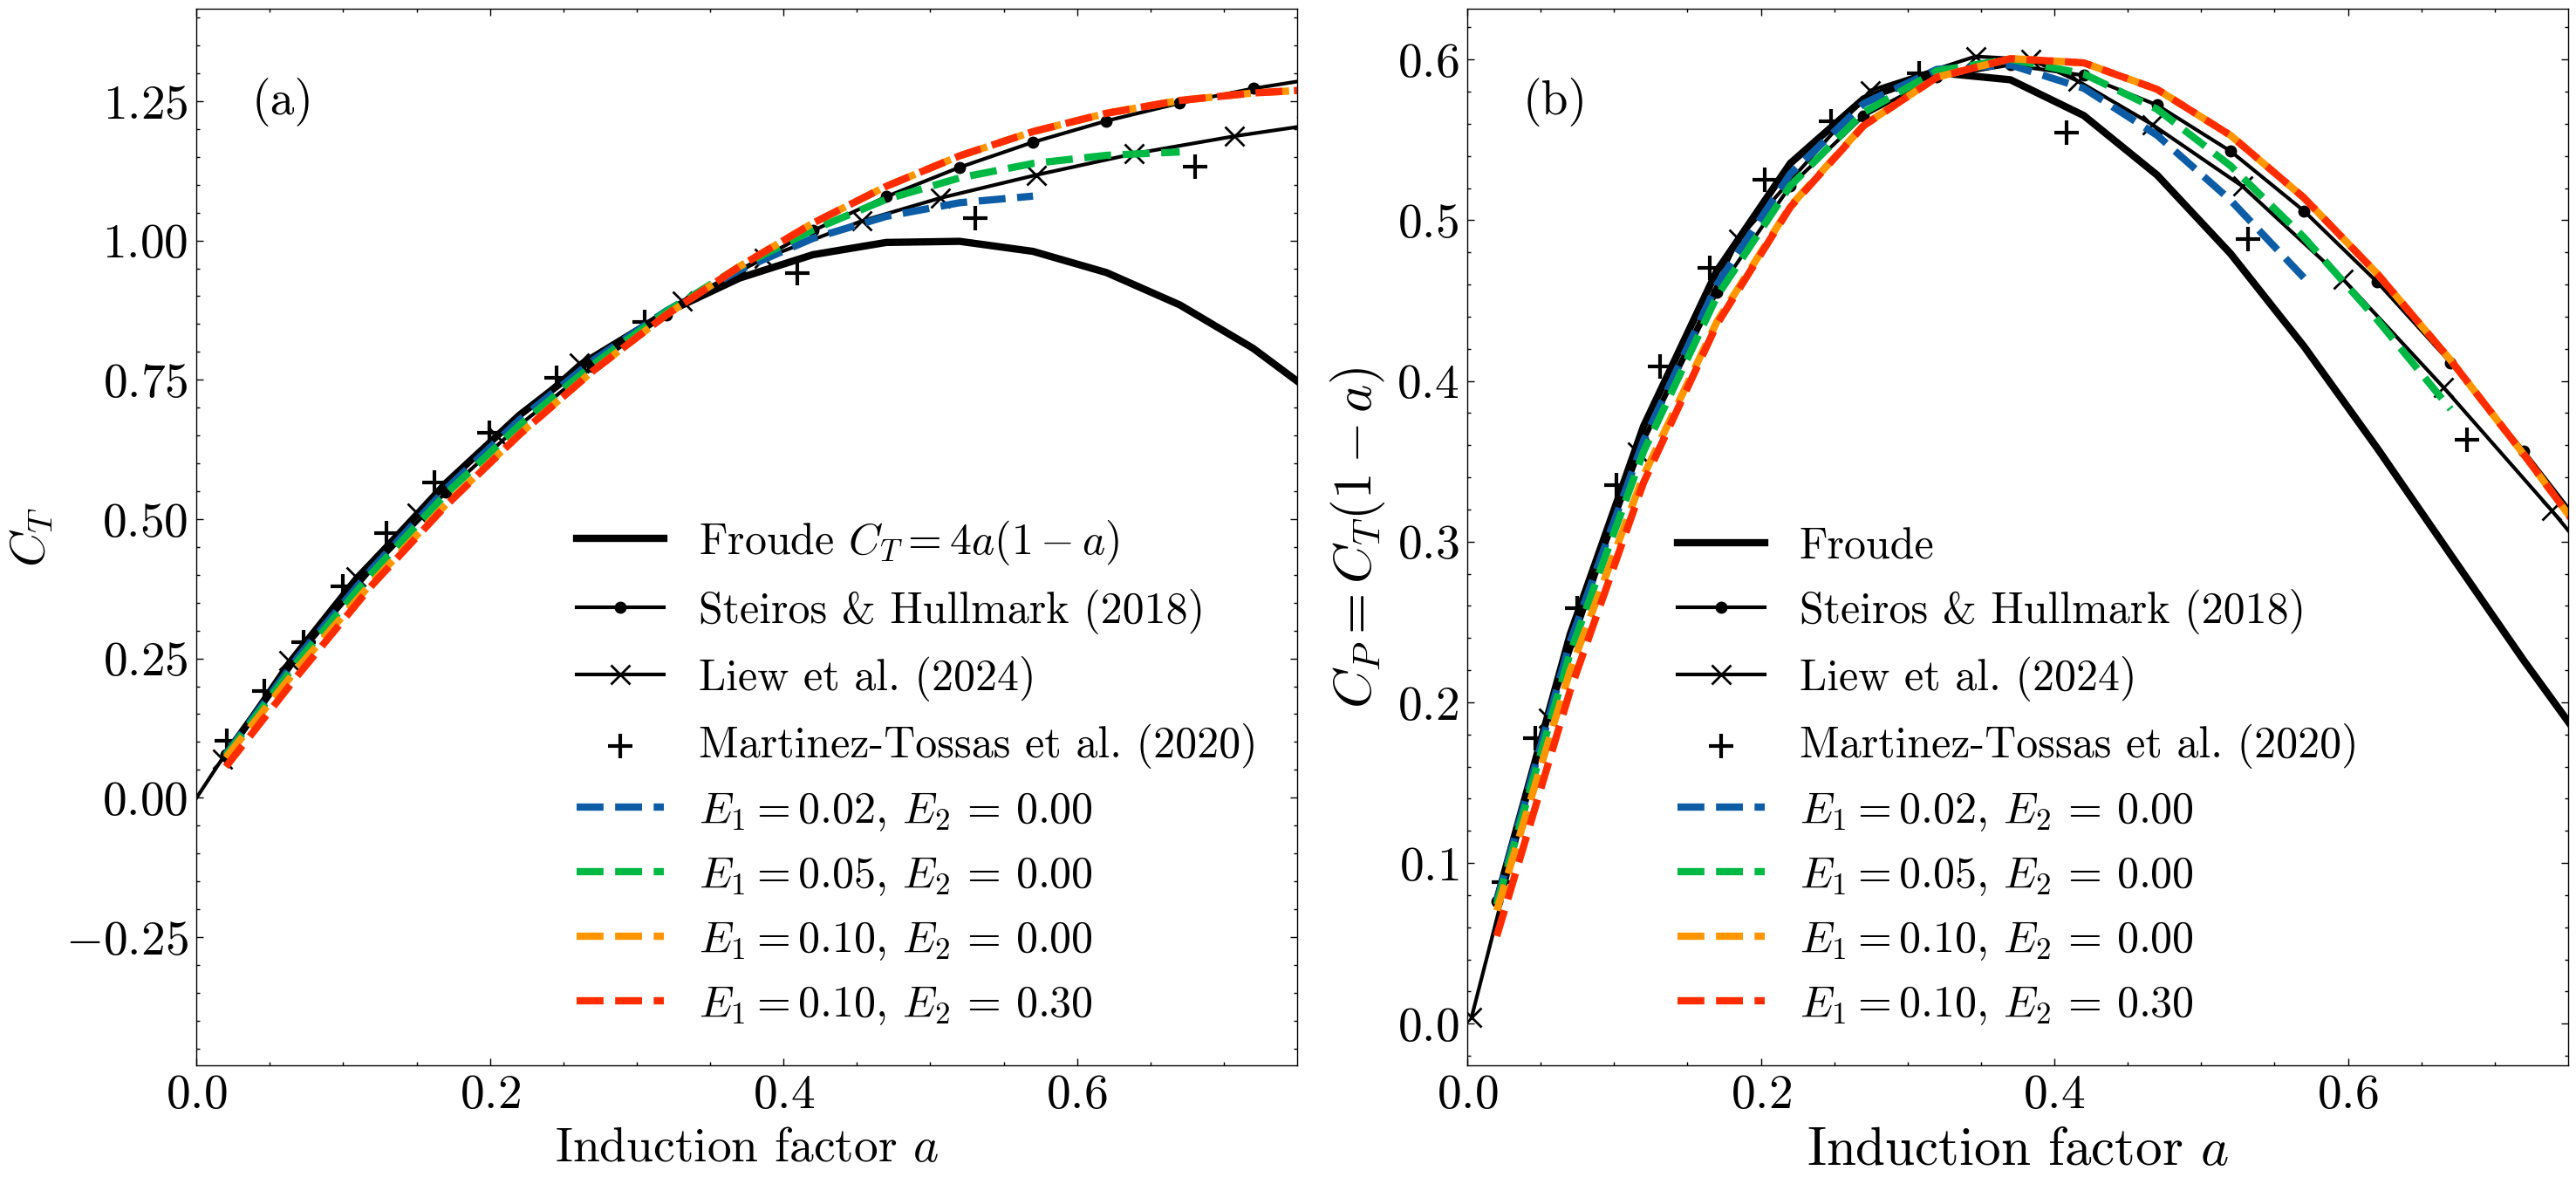

In [6]:
############### PLOTTING #######################
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharex=False)
f1 = 20  # Font size

#---------------------------------------------
# PLOT MODELS/DATA FROM LITERATURE
#---------------------------------------------
# Subplot 1: CT vs a
AA=np.arange(0.02, .85, .05)  # induction factor values used to plot models from the literature
axs[0].plot(AA, CT_Froude(AA), label="Froude $C_T=4a(1-a)$", color='Black',linewidth=3,linestyle='-')
axs[0].plot(AA, CT_Steiros(AA), label="Steiros & Hullmark (2018)", color='Black',linewidth=1.5,linestyle='-',marker='.',markersize=8)
axs[0].plot(mit_ct['a'], mit_ct['CT'], label='Liew et al. (2024)', color='black',linewidth=1.5,linestyle='-',marker='x',markersize=8)
axs[0].scatter(nrel_ct['a'], nrel_ct['CT'], label='Martinez-Tossas et al. (2020)', color='black', marker='+',s=100,linewidths=1.5)
axs[0].set_xlabel("Induction factor $a$", fontsize=f1)
axs[0].set_ylabel("$C_T$", fontsize=f1)
axs[0].grid(False)

# Subplot 2: CP vs a
axs[1].plot(AA, CT_Froude(AA) * (1 - AA), label="Froude", color='Black',linewidth=3,linestyle='-')
axs[1].plot(AA, CT_Steiros(AA) * (1 - AA), label="Steiros & Hullmark (2018)", color='black',linewidth=1.5,linestyle='-',marker='.',markersize=8)
axs[1].plot(mit_cp['a'], mit_cp['CP'], label='Liew et al. (2024)', color='black',linewidth=1.5,linestyle='-',marker='x',markersize=8)
axs[1].scatter(nrel_cp['a'], nrel_cp['CP'], label='Martinez-Tossas et al. (2020)', color='black', marker='+',s=100,linewidths=1.5)
axs[1].set_xlabel("Induction factor $a$", fontsize=f1+2)
axs[1].set_ylabel("$C_P=C_T(1-a)$", fontsize=f1+2)
axs[1].grid(False)



#---------------------------------------------
# ADD CT and CP RESULTS GENERATED BY THE NEW AD MODEL
#---------------------------------------------
I = 0.05       # incoming turbulence intensity
EE = [(0.02, 0), (.05, 0), (0.1, 0), (0.1, 0.3)] # (E1,E2) values

#---------------------------------------    
#        A INPUT --> CT OUTPUT 
#---------------------------------------
A = np.arange(0.02, .85, .05)  
CT = np.zeros_like(A)   

#---------------------------------------    
#        CT INPUT --> A OUTPUT 
#---------------------------------------
# CT= np.arange(0.02, 1.3, .05)  
# A = np.zeros_like(CT)

for E1, E2 in EE:
    
    #---------------------------------------    
    #        A INPUT --> CT OUTPUT 
    #---------------------------------------
    for i, a in enumerate(A): # For "a" input and CT output
        CT[i] = new_AD(E1, E2, I,a=a)[4] 

    #---------------------------------------    
    #        CT INPUT --> A OUTPUT 
    #---------------------------------------
#     for i, ct in enumerate(CT): # For CT input and "a" output
#         A[i] = new_AD(E1, E2, I,ct=ct)[4] 
        
    ########################################
    axs[0].plot(A, CT, label=f'$E_1 = ${E1:.2f}, $E_2  $ = {E2:.2f}',linewidth=3,linestyle='--')
    CP = CT * (1 - A)
    axs[1].plot(A, CP, label=f'$E_1 = ${E1:.2f}, $E_2  $ = {E2:.2f}',linewidth=3,linestyle='--')

# Panel letters
axs[0].text(0.05, 0.9, "(a)", transform=axs[0].transAxes,
             fontsize=20, weight="bold")
axs[1].text(0.05, 0.9, "(b)", transform=axs[1].transAxes,
             fontsize=20, weight="bold")

for ax in axs:
    ax.tick_params(axis='both', labelsize=f1)
    ax.set_xlim([0, .75])
    ax.legend(fontsize=f1 - 2)
    

plt.tight_layout()
plt.show()


